In [7]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- RDKit for molecular fingerprint extraction ---
from rdkit import Chem
from rdkit.Chem import AllChem

def smiles_to_fp(smiles, n_bits=256, radius=2):
    mol = Chem.MolFromSmiles(smiles) if pd.notna(smiles) else None
    if mol is None:
        return np.zeros(n_bits, dtype=int)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.asarray(fp)
    return arr

print(smiles_to_fp('CCO').shape)

(256,)


[14:16:54] DEPRECATION WARNING: please use MorganGenerator


In [8]:
# --- Load raw data ---
b2f_mlmodel_df = pd.read_csv('../ylab-ML-MODEL/data/batch2flow_updated.csv', index_col='item')
print("Columns:", b2f_mlmodel_df.columns)

# --- Manually or automatically identify SMILES columns ending with _B or by chemical column names ---
possible_smiles_cols = [col for col in b2f_mlmodel_df.columns if (
    col.endswith('_B') or col in ['reagent1', 'reagent2', 'reagent3', 'solvent', 'additive1', 'catalyst']
)]
# Check actual string type
smiles_cols = [col for col in possible_smiles_cols if b2f_mlmodel_df[col].dtype == 'object']
print("SMILES columns:", smiles_cols)

Columns: Index(['F/B', 'reagent1', 'requiv1', 'reagent2', 'requiv2', 'reagent3',
       'requiv3', 'solvent', 'csolv', 'additive1', 'addequiv1', 'additive2',
       'addequiv2', 'catalyst1', 'catequiv1', 'catalyst2', 'catequiv2',
       'pcagtalyst', 'pcequiv', 'temp', 'time', 'wavelength', 'power',
       'product ', 'yield', 'doi'],
      dtype='object')
SMILES columns: ['reagent1', 'reagent2', 'reagent3', 'solvent', 'additive1']


In [ ]:
# --- Convert all SMILES columns to fingerprint matrices and concatenate ---
n_bits = 256  # To avoid feature explosion

fp_feature_frames = []
for col in smiles_cols:
    # Compute fingerprint matrix for column
    fp_mat = np.stack(b2f_mlmodel_df[col].fillna('').apply(smiles_to_fp, n_bits=n_bits))
    fp_df = pd.DataFrame(fp_mat, index=b2f_mlmodel_df.index, columns=[f"{col}_fp{i}" for i in range(n_bits)])
    fp_feature_frames.append(fp_df)

# --- Merge all fingerprints with the original data (excluding original SMILES) ---
numeric_df = b2f_mlmodel_df.drop(columns=smiles_cols)
merged_df = pd.concat([numeric_df] + fp_feature_frames, axis=1)
merged_df.head()

[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerator
[14:17:00] DEPRECATION WARNING: please use MorganGenerat

,F/B,requiv1,requiv2,requiv3,csolv,addequiv1,additive2,addequiv2,catalyst1,catequiv1,...,additive1_fp246,additive1_fp247,additive1_fp248,additive1_fp249,additive1_fp250,additive1_fp251,additive1_fp252,additive1_fp253,additive1_fp254,additive1_fp255
item,,,,,,,,,,,,,,,,,,,,,
1,F,1,1.0,1.0,0.25,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,B,1,1.0,1.0,0.10,0.1,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
3,F,1,1.0,1.0,0.10,0.1,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
4,B,1,1.0,1.0,0.25,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5,F,1,2.0,NaN,0.05,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# --- Clean missing columns, pivot to wide format for ML modeling ---

# Keep only numeric columns and F/B for pivot
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
fb = merged_df[['F/B']]
numeric_merged_df = pd.concat([fb, merged_df[numeric_cols]], axis=1)

# Remove columns with too many missing values
missing_frac = numeric_merged_df.isnull().mean()
cols_to_drop = missing_frac[missing_frac > 1].index.tolist()
df = numeric_merged_df.drop(columns=cols_to_drop).copy()

# Assign batch number, reshape to wide format (pivot)
df['batch'] = ((df.index + 1) // 2).astype(int)
flow_vars = [c.replace('_B', '').replace('_F', '') for c in numeric_cols if not c.startswith('exist_')]
df_wide = df.pivot(index='batch', columns='F/B', values=flow_vars)
df_wide.columns = [f"{var}_{fb}" for var, fb in df_wide.columns]
df_wide = df_wide.reset_index()

# Reorder columns for ML (all _B, then all _F)
f_cols = sorted([c for c in df_wide if c.endswith('_F')])
b_cols = sorted([c for c in df_wide if c.endswith('_B')])
df_reordered = df_wide[['batch'] + b_cols + f_cols].set_index('batch')
df_full = df_reordered.fillna(0)
df_full

,addequiv1_B,addequiv2_B,additive1_fp0_B,additive1_fp100_B,additive1_fp101_B,additive1_fp102_B,additive1_fp103_B,additive1_fp104_B,additive1_fp105_B,additive1_fp106_B,...,solvent_fp95_F,solvent_fp96_F,solvent_fp97_F,solvent_fp98_F,solvent_fp99_F,solvent_fp9_F,temp_F,time_F,wavelength_F,yield_F
batch,,,,,,,,,,,,,,,,,,,,,
1,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,120.0,530.0,98.0
2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,10.0,530.0,72.0
3,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,360.0,0.0,82.0
4,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1080.0,400.0,62.0
5,3.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,6.0,527.0,63.0
6,3.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,6.0,527.0,65.0
7,3.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,6.0,527.0,20.0
8,3.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,6.0,527.0,22.0
9,3.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,6.0,527.0,71.0


In [11]:
# --- Add 'exist_' flag columns: 1 if value != 0, else 0 ---
all_features = b_cols + f_cols
for feat in all_features:
    df_full[f"exist_{feat}"] = (df_full[feat] != 0).astype(int)

# --- Build interleaved columns for ML input ---
new_cols = []
for feat in all_features:
    new_cols.append(feat)
    new_cols.append(f"exist_{feat}")
df_exist = df_full[new_cols].copy()
df_exist.head()

/var/folders/sv/9qk0q51529zcmnr0zlnz59c00000gn/T/ipykernel_93373/409394128.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_full[f"exist_{feat}"] = (df_full[feat] != 0).astype(int)
/var/folders/sv/9qk0q51529zcmnr0zlnz59c00000gn/T/ipykernel_93373/409394128.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_full[f"exist_{feat}"] = (df_full[feat] != 0).astype(int)
/var/folders/sv/9qk0q51529zcmnr0zlnz59c00000gn/T/ipykernel_93373/409394128.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

,addequiv1_B,exist_addequiv1_B,addequiv2_B,exist_addequiv2_B,additive1_fp0_B,exist_additive1_fp0_B,additive1_fp100_B,exist_additive1_fp100_B,additive1_fp101_B,exist_additive1_fp101_B,...,solvent_fp9_F,exist_solvent_fp9_F,temp_F,exist_temp_F,time_F,exist_time_F,wavelength_F,exist_wavelength_F,yield_F,exist_yield_F
batch,,,,,,,,,,,,,,,,,,,,,
1,0.10,1,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,25.0,1,120.0,1,530.0,1,98.0,1
2,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,25.0,1,10.0,1,530.0,1,72.0,1
3,0.05,1,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,25.0,1,360.0,1,0.0,0,82.0,1
4,1.10,1,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,50.0,1,1080.0,1,400.0,1,62.0,1
5,3.50,1,0.0,0,0.0,0,1.0,1,0.0,0,...,0.0,0,25.0,1,6.0,1,527.0,1,63.0,1


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. original target variables
target_vars = [
    'requiv2_F', 'requiv3_F', 'csolv_F', 'addequiv1_F', 'addequiv2_F',
    'catequiv1_F', 'catequiv2_F', 'pcequiv_F', 'temp_F', 'time_F'
]

# 2. setup feature_cols: _B + exist_*_B + fingerprint
b_features = [col for col in df_full.columns if col.endswith('_B')]
exist_features = [col for col in df_exist.columns if col.startswith('exist_') and col.endswith('_B')]

# assume fingerprint column name _fp0/_fp1... as end, eg. fp_cols = [col for col in df_full.columns if col.startswith('smiles_fp')]
fp_features = [col for col in df_full.columns if '_fp' in col]
feature_cols = list(dict.fromkeys(b_features + exist_features + fp_features))

# 3. target variables
f_features = target_vars

# 4. Build input/output
X = df_exist[feature_cols].values
y = df_full[f_features].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)

# 6. Train MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 512, 256, 128),
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    max_iter=5000,
    early_stopping=False,
    tol=1e-6,
    random_state=42,
    verbose=True
)
mlp.fit(X_train_scaled, y_train_scaled)

# 7. Predict and inverse scale, force negative to 0
pred_scaled = mlp.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(pred_scaled)
y_pred = np.clip(y_pred, 0, None)

# 8. Assemble result DataFrame (仅老10个目标)
X_test_df = pd.DataFrame(X_test, columns=feature_cols)
y_test_df = pd.DataFrame(y_test, columns=f_features)
pred_df = pd.DataFrame(y_pred, columns=[f"predicted_{c}" for c in f_features])
combined_df = pd.concat([X_test_df, y_test_df, pred_df], axis=1)

pd.DataFrame(combined_df)

# 9. exist_*_B == 0 predicted value need equal 0 must be

for fcol in f_features:
    pred_col = f'predicted_{fcol}'
    combined_df.loc[combined_df[fcol] == 0, pred_col] = 0

# 10. Again, ensure no small negatives
for fcol in f_features:
    pred_col = f'predicted_{fcol}'
    if pred_col in combined_df.columns:
        combined_df[pred_col] = combined_df[pred_col].clip(lower=0)

pd.DataFrame(combined_df)


Iteration 1, loss = 0.53196802
Iteration 2, loss = 0.36996101
Iteration 3, loss = 0.25822001
Iteration 4, loss = 0.15678291
Iteration 5, loss = 0.09632233
Iteration 6, loss = 0.06511816
Iteration 7, loss = 0.05129433
Iteration 8, loss = 0.05026798
Iteration 9, loss = 0.04146842
Iteration 10, loss = 0.02745998
Iteration 11, loss = 0.01697605
Iteration 12, loss = 0.01400271
Iteration 13, loss = 0.01476168
Iteration 14, loss = 0.01598933
Iteration 15, loss = 0.01412011
Iteration 16, loss = 0.01046679
Iteration 17, loss = 0.00809529
Iteration 18, loss = 0.00843348
Iteration 19, loss = 0.00922376
Iteration 20, loss = 0.00825204
Iteration 21, loss = 0.00639868
Iteration 22, loss = 0.00504632
Iteration 23, loss = 0.00445325
Iteration 24, loss = 0.00449778
Iteration 25, loss = 0.00448366
Iteration 26, loss = 0.00423601
Iteration 27, loss = 0.00380552
Iteration 28, loss = 0.00361582
Iteration 29, loss = 0.00373470
Iteration 30, loss = 0.00374010
Iteration 31, loss = 0.00329720
Iteration 32, los

,addequiv1_B,addequiv2_B,additive1_fp0_B,additive1_fp100_B,additive1_fp101_B,additive1_fp102_B,additive1_fp103_B,additive1_fp104_B,additive1_fp105_B,additive1_fp106_B,...,predicted_requiv2_F,predicted_requiv3_F,predicted_csolv_F,predicted_addequiv1_F,predicted_addequiv2_F,predicted_catequiv1_F,predicted_catequiv2_F,predicted_pcequiv_F,predicted_temp_F,predicted_time_F
0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.500895,0.0,0.049639,1.501264,0.0,0.100852,0.0,0.0201,39.961700,12.987973
1,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.932328,0.0,0.119291,1.963158,0.0,0.000000,0.0,0.0000,29.908330,203.193995
2,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.884951,0.0,0.114804,2.037427,0.0,0.000000,0.0,0.0000,30.401251,190.981323
3,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.709759,0.0,0.125864,1.757904,0.0,0.000000,0.0,0.0000,30.670273,245.811534
4,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.896057,0.0,0.115859,1.989449,0.0,0.000000,0.0,0.0000,29.673331,192.170741
5,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.894942,0.0,0.120731,1.989436,0.0,0.000000,0.0,0.0000,29.978881,200.891214
6,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.853690,0.0,0.127134,1.912664,0.0,0.000000,0.0,0.0000,29.788498,225.726562
7,3.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.477237,3.167119,0.0,0.052578,0.0,0.0000,25.480357,14.658060
8,3.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.424294,3.278116,0.0,0.042230,0.0,0.0000,25.621222,30.507163
9,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.783062,0.0,0.121461,2.029801,0.0,0.000000,0.0,0.0000,29.566274,177.120726


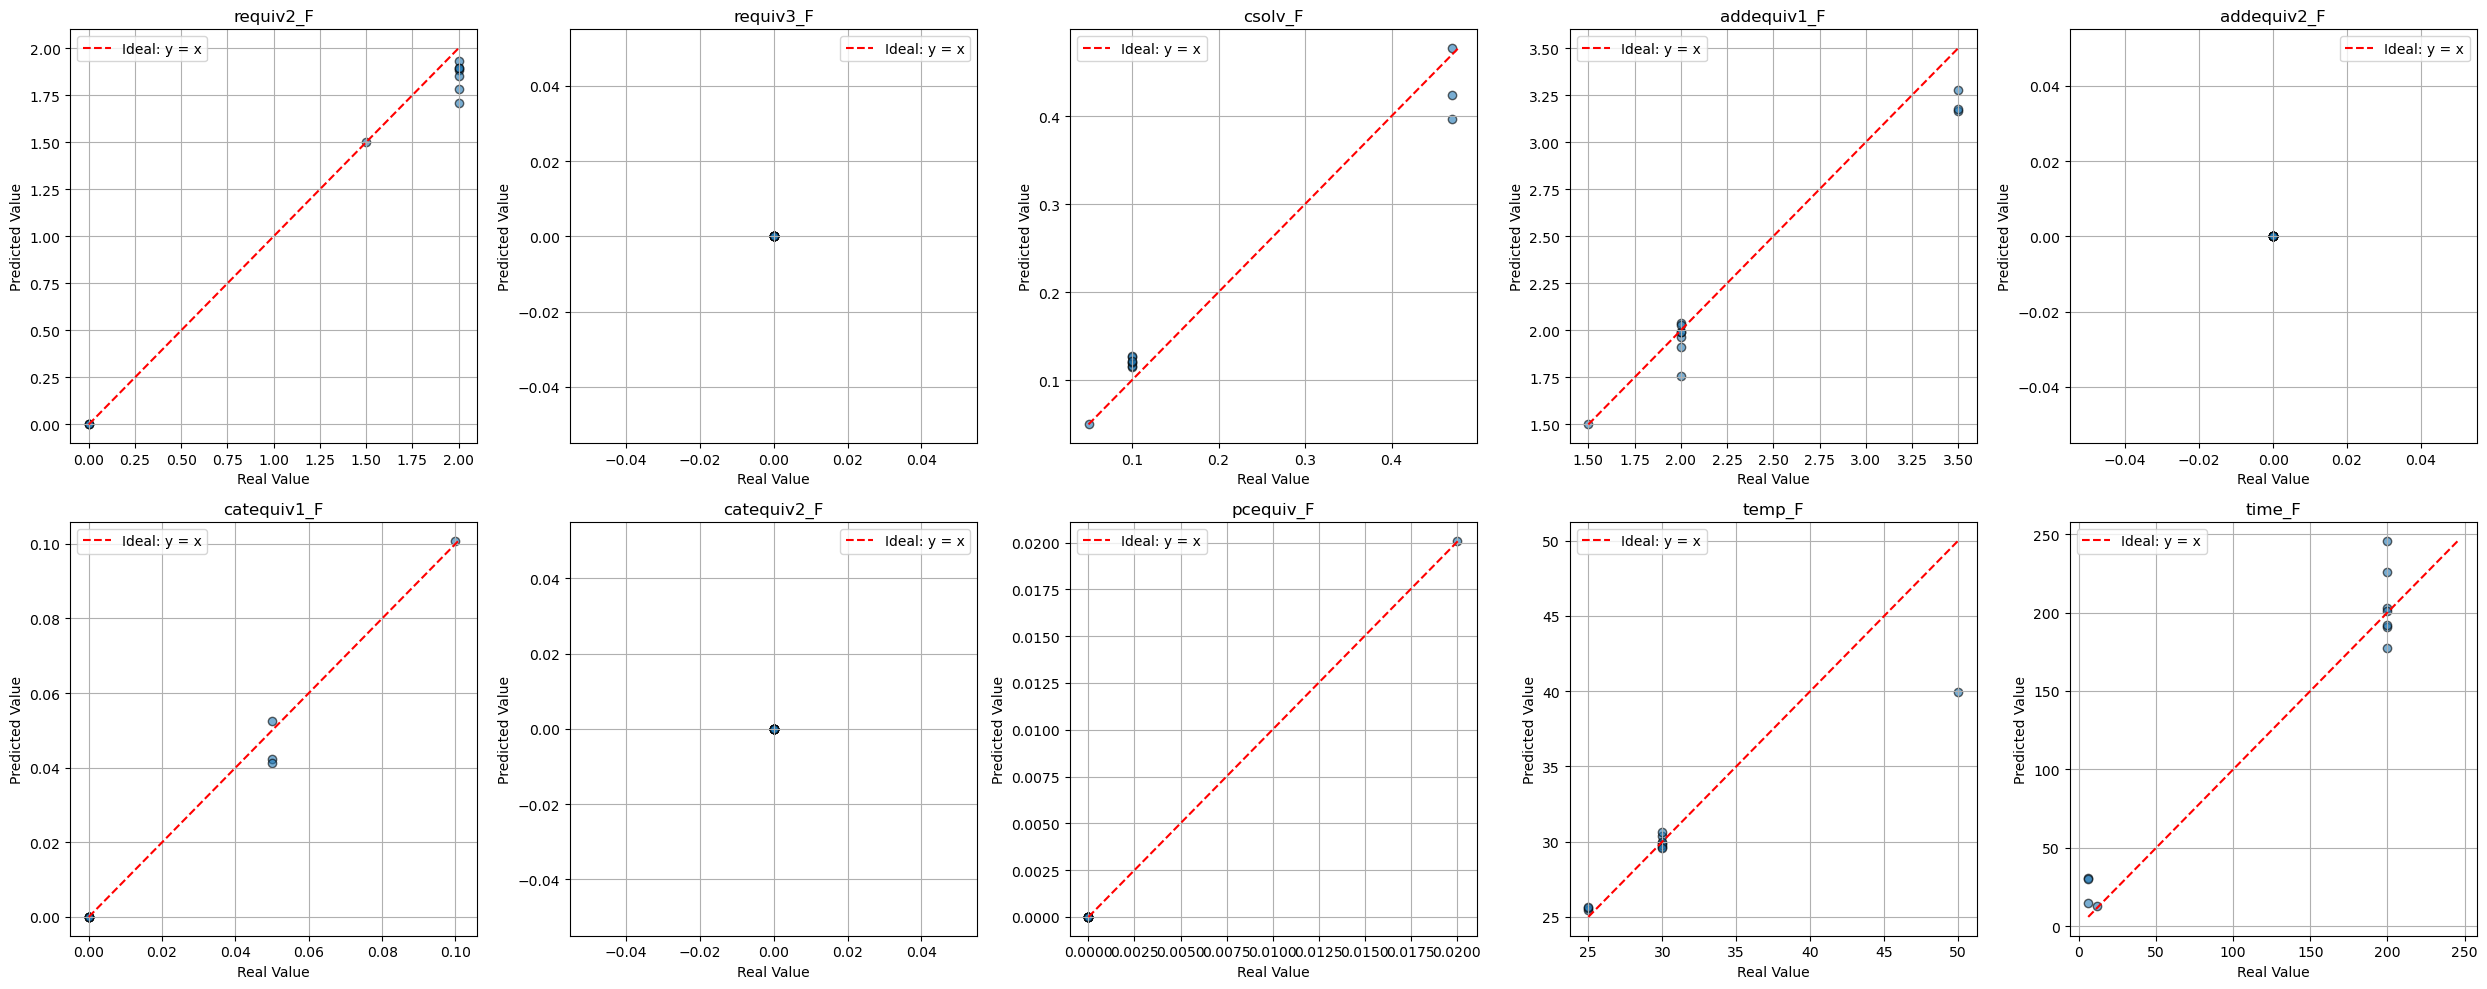

In [29]:
# 11. Only plot the 10 original variables           
import matplotlib.pyplot as plt

n_plots = len(f_features)
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols

plt.figure(figsize=(5*n_cols, 5*n_rows))
for i, col in enumerate(f_features):
    plt.subplot(n_rows, n_cols, i+1)
    # x: Real, y: Predicted
    plt.scatter(combined_df[col], combined_df[f"predicted_{col}"], alpha=0.6, edgecolor='k')
    min_val = min(combined_df[col].min(), combined_df[f"predicted_{col}"].min())
    max_val = max(combined_df[col].max(), combined_df[f"predicted_{col}"].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal: y = x')
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title(col)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()
